In [119]:
import igraph as ig
import numpy as np
import os
from collections import Counter, defaultdict, OrderedDict
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from auxiliar_bb import apply_backboning
from auxiliar_projections_large import apply_projection
from auxiliar_optimization import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [120]:
### Select dataset
DATASET = "amz" # ["amz", "um", "am"]
PROJ_NAMES = ["simple", "vector", "jaccard", "neighs", "hyper", "resall"]

nombre_proyecciones = {
    "simple": "Weighted", "jaccard": "Jaccard", "hyper": "Hyperbolic",
    "vector": "Vectorized", "resall": "Resource\nAllocation", "neighs": "Neighborhood"
}
nombre_backbonings = { "NC": "Noise Corrected", "DF": "Disparity Filter"}
COLORS_PR = ["#ef476fff", "#f78c6bff", "#ffd166ff", "#06d6a0ff", "#118ab2ff", "#718355"]
COLORS_BB = [ "#8ab17d", "#e9c46a"]
COLORS_SV = ["#718355", "#87986a", "#97a97c", "#b5c99a"]

if DATASET == "um":
    FILENAME = "../12-third_year/00-Data/08-imdb/user-movie.graphml"
elif DATASET == "am":
    FILENAME = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/00-Data/05-actor-movie/actor-movie.graphml"
elif DATASET == "amz":
    FILENAME = "binet-AMZ-Rw.graphml"


In [125]:
# Auxiliar functions
def plot_pie_subplots(proyecciones, backbonings, significancias, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    categories = [
        (proyecciones, "Projections types"),
        (backbonings, "Backboning methods"),
        (OrderedDict(sorted(significancias.items(), key=lambda x: float(x[0]))), "Significance value")
    ]
    color_counter = 0
    for ax, (data, subtitle) in zip(axes, categories):
        labels = list(data.keys())
        sizes = list(data.values())

        if color_counter == 0:
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=COLORS_PR)
        elif color_counter == 1:
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=COLORS_BB)
        else:
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=COLORS_SV)
        color_counter += 1
        ax.set_title(subtitle)
        ax.axis('equal')

    fig.suptitle(f"Distribution of network instance characteristics - {title}", fontsize=14)
    plt.tight_layout()
    plt.savefig(title + "-pastel.png")
    plt.show()

# Función principal
def analizar_frente(front, nombre="Frente"):
    proyecciones = Counter()
    backbonings = Counter()
    significancias = Counter()

    for sol in front:
        if isinstance(sol, dict):
            fname = sol["filename"]
        else:
            fname = sol

        parts = fname.split("_")
        if len(parts) == 3:
            proj, back, alpha = parts

            proj_label = nombre_proyecciones.get(proj, proj)
            back_label = nombre_backbonings.get(back, back)

            proyecciones[proj_label] += 1
            backbonings[back_label] += 1

            if alpha.startswith('a'):
                alpha_val = alpha[1:]
                if len(alpha_val) == 1:
                    alpha_val = f"0.{alpha_val}0"
                elif len(alpha_val) == 2:
                    alpha_val = f"0.{alpha_val}"
                else:
                    alpha_val = f"0.{alpha_val[:2]}"
                significancias[alpha_val] += 1

    print(f"\nResumen para {nombre}")
    print("Proyecciones:", dict(proyecciones))
    print("Backbonings:", dict(backbonings))
    print("Significancias:", dict(significancias))

    # Mostrar los subplots
    plot_pie_subplots(proyecciones, backbonings, significancias, nombre)

### Load dataset

In [3]:
g = ig.read(FILENAME)
print(g.summary())
print()

top_nodes = g.vs.select(type=0)
bot_nodes = g.vs.select(type=1)

print("|U|=",len(top_nodes), " \t|R|=",len(bot_nodes), " \t|U|+|R|=",
      len(top_nodes)+len(bot_nodes), "=", g.vcount())
print()

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()


IGRAPH U-WT 17079 32769 -- 
+ attr: freq (v), id (v), type (v), weight (e)

|U|= 9561  	|R|= 7518  	|U|+|R|= 17079 = 17079

The graph IS bipartite


### Apply projection and backboning

In [11]:
for proj_opcion in PROJ_NAMES:
    ###### ****** Projections ****** ######
    top_graph = apply_projection(g, proj_opcion,
                                len(top_nodes), False) # False = Users = 0
    print("Done PROJ1 - Users Projection")
    edges_temp = top_graph.es()["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")

    bot_graph = apply_projection(g, proj_opcion,
                                len(top_nodes), True) # True = Resources = 1
    print("\nDone PROJ2 - Resources Projection")
    edges_temp = bot_graph.es()["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")
    print()

    ### Applying backboning
    for i, graph_type in enumerate([top_graph, bot_graph]):
        apply_backboning(graph_type, dataset=DATASET, proj_opcion=proj_opcion, nodetype=i, remove_zeros=False)
    

Done PROJ1 - Users Projection
Peso máximo=8 y mínimo=1 en aristas: 

Done PROJ2 - Resources Projection
Peso máximo=82 y mínimo=1 en aristas: 


##### **** BACKBONING USERS **** #####
Projection Name: simple
Summary
 IGRAPH U-WT 9561 1253277 -- 
+ attr: freq (v), id (v), type (v), weight (e)
##### END #####

Peso máximo=8 y mínimo=1 en aristas: 

Factor de escala: 1
Peso máximo=8 y mínimo=1 en aristas: 

TOP DF - time: 0.4112384319 seconds.
Grafo filtrado con alpha=0.05: IGRAPH U-WT 8345 1663 -- 
+ attr: freq (v), id (v), type (v), weight (e)
Grafo filtrado con alpha=0.1: IGRAPH U-WT 8691 9703 -- 
+ attr: freq (v), id (v), type (v), weight (e)
Grafo filtrado con alpha=0.15: IGRAPH U-WT 9408 29456 -- 
+ attr: freq (v), id (v), type (v), weight (e)
Grafo filtrado con alpha=0.2: IGRAPH U-WT 9408 74723 -- 
+ attr: freq (v), id (v), type (v), weight (e)
TOP NC - time: 0.7733087540 seconds.
Grafo filtrado con alpha=0.05: IGRAPH U-WT 9560 569794 -- 
+ attr: freq (v), id (v), type (v), weight (

## Optimization type TOP

In [122]:
NODETYPE = 0   # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics

/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


{'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 1,
 'x9': 5.693348296637462,
 'x11': 3.8553228787812426}

In [123]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")
proj_files = [f for f in os.listdir(proj_dir) if f.endswith(".graphml")]

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

solutions = []
to_df = []
names_df = []
k = 100  # For approximation

for fname in proj_files:
    graph_path = os.path.join(proj_dir, fname)
    gu = ig.Graph.Read_GraphML(graph_path)
    gu = remove_isolated_nodes(gu, k=5)

    # Nombre base del archivo (sin extensión)
    base_name = fname[:-8]
    cache_path = os.path.join(metrics_cache_dir, f"{base_name}_metrics.pkl")

    # Verificar si ya existe un archivo de métricas cacheado
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            proj_metrics = pickle.load(f)
    else:
        k_approx = min(k, gu.vcount())
        proj_metrics = compute_proj_metrics(gu, k_approx)
        with open(cache_path, 'wb') as f:
            pickle.dump(proj_metrics, f)

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(proj_files))
print("Feasible solutions:", len(solutions))


All solutions: 48
Feasible solutions: 40



Frente 1 (36 soluciones):
simple_NC_a15
jaccard_NC_a15
simple_NC_a2
hyper_DF_a1
resall_NC_a2
neighs_NC_a15
neighs_DF_a2
resall_NC_a05
vector_NC_a05
jaccard_DF_a15
neighs_DF_a15
neighs_DF_a1
resall_NC_a1
resall_DF_a2
neighs_NC_a1
vector_DF_a15
simple_NC_a1
simple_NC_a05
jaccard_NC_a05
hyper_NC_a05
hyper_NC_a1
hyper_NC_a15
resall_DF_a1
neighs_NC_a2
jaccard_DF_a1
hyper_DF_a15
vector_NC_a15
neighs_NC_a05
jaccard_DF_a2
vector_DF_a2
resall_NC_a15
hyper_DF_a2
resall_DF_a15
hyper_NC_a2
resall_DF_a05
hyper_DF_a05

Frente 2 (4 soluciones):
vector_NC_a1
jaccard_NC_a2
vector_NC_a2
jaccard_NC_a1

Resumen para AMZ Top
Proyecciones: {'Weighted': 4, 'Jaccard': 7, 'Hyperbolic': 8, 'Resource\nAllocation': 8, 'Neighborhood': 7, 'Vectorized': 6}
Backbonings: {'Noise Corrected': 24, 'Disparity Filter': 16}
Significancias: {'0.15': 11, '0.20': 11, '0.10': 10, '0.05': 8}


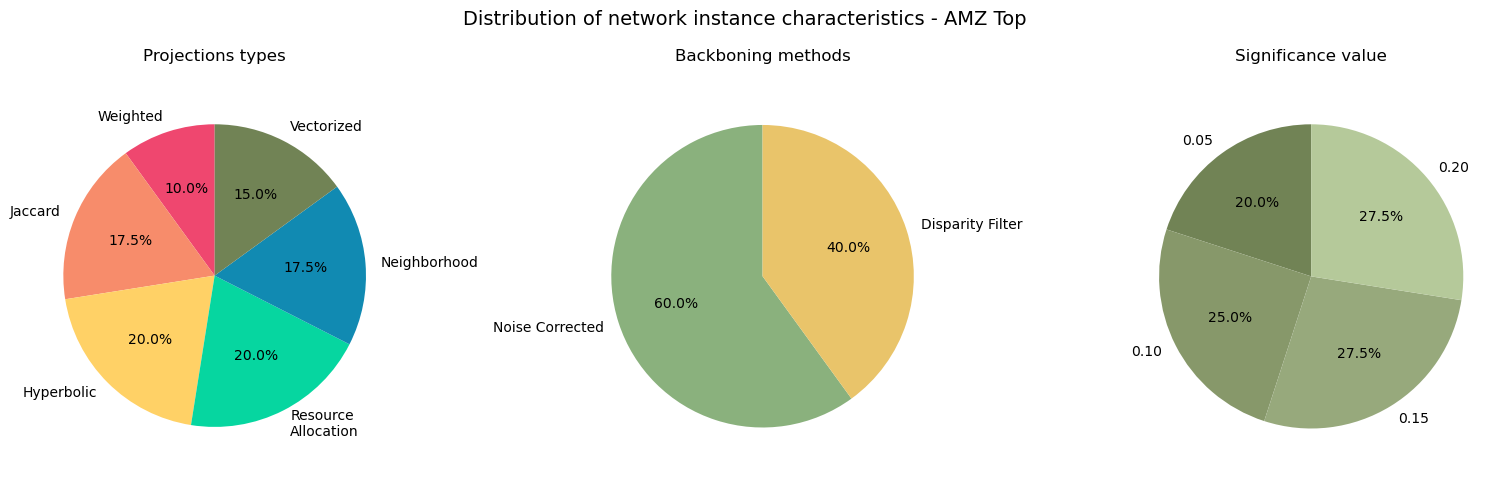

In [126]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][8:]
        print(clean_name)
        counter_sols.append(clean_name)

analizar_frente(counter_sols, DATASET.upper()+" Top")

In [127]:
cd = crowding_distance(all_fronts[0])
pareto_sorted = [s for _, s in sorted(zip(-cd, all_fronts[0]), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))

Crowding 36


### Plotting

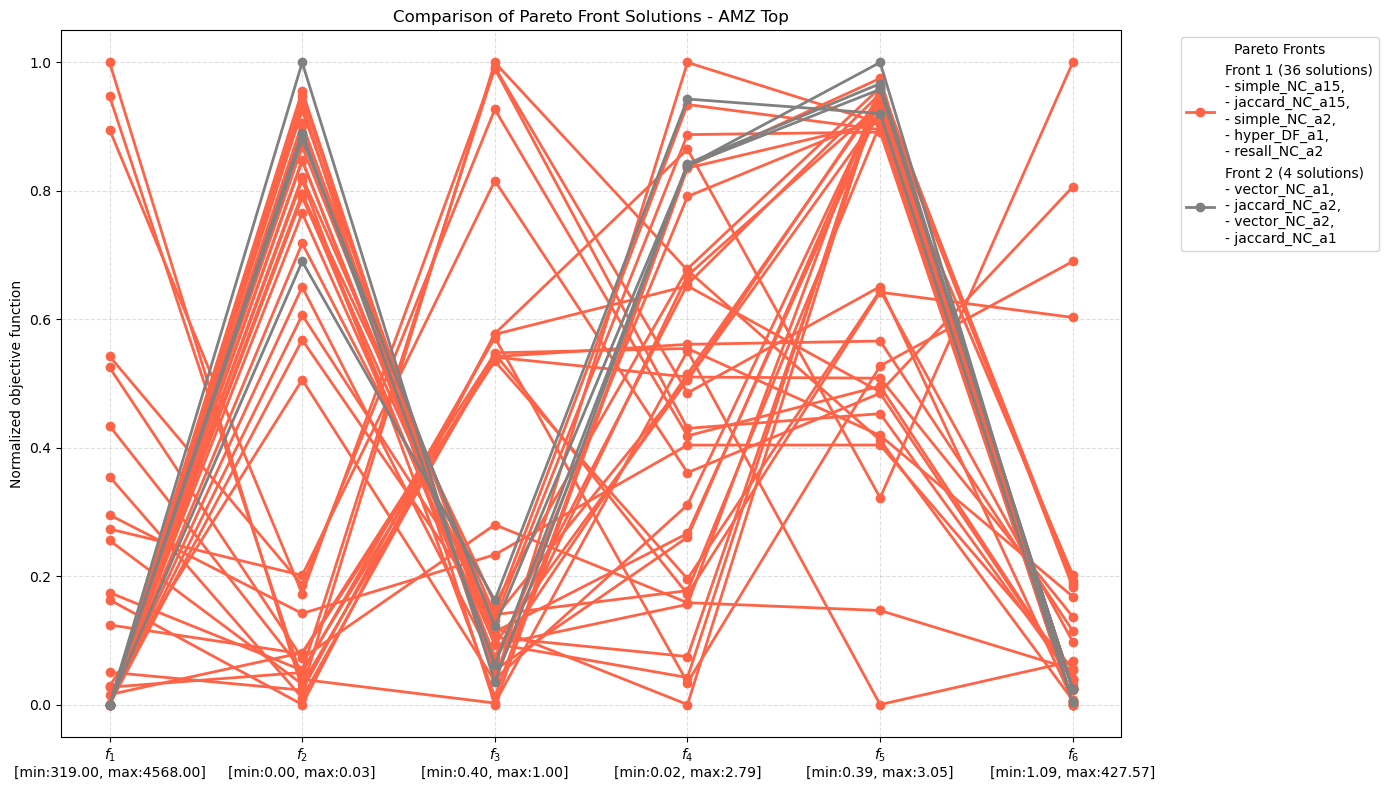

In [128]:
# --- Fin de la simulación de datos ---

labels = ["$f_1$", "$f_2$", "$f_3$", "$f_4$", "$f_5$", "$f_6$"]

# 1. Aplanar la lista de frentes para normalizar todos los datos juntos
todas_las_soluciones = [sol for front in all_fronts for sol in front]
F_all = np.array([sol["f"] for sol in todas_las_soluciones])

# 2. Calcular los valores mínimo y máximo de cada función objetivo
min_vals = F_all.min(axis=0)
max_vals = F_all.max(axis=0)

# 3. Normalizar todos los valores
F_norm_all = (F_all - min_vals) / (max_vals - min_vals + 1e-8)

# 4. Preparar la figura para la gráfica
plt.figure(figsize=(14, 8))

# Generar una escala de grises
num_frentes = len(all_fronts)
# Usar `np.linspace` para generar valores de gris desde un tono oscuro a uno claro.
# Por ejemplo, desde un gris 0.2 (oscuro) hasta 0.8 (claro).
gray_scale = np.linspace(0.2, 0.8, num_frentes+1)

# 5. Recorrer los frentes y las soluciones para graficar
idx_solucion = 0
for i, front in enumerate(all_fronts):
    rank = i + 1
    num_sols = len(front)

    # Asignar el color del frente
    if i == 0:
        color = "tomato"
    else:
        color = str(gray_scale[i])

    # Generar nombres de soluciones (puedes ajustar esto si tus soluciones tienen un identificador propio)
    nombres_soluciones = [sol.get("filename", f"sol_{idx_solucion + j}") for j, sol in enumerate(front)]
    nombres_soluciones = [i[8:] for i in nombres_soluciones]
    nombres_mostrados = ",\n- ".join(nombres_soluciones[:5])
    
    # Etiqueta extendida para la leyenda
    label_front = f"Front {rank} ({num_sols} solutions)"
    if num_sols > 0:
        label_front += f"\n- {nombres_mostrados}"

    for j, sol in enumerate(front):
        F_norm_solucion = F_norm_all[idx_solucion]

        # Solo la primera solución del frente tiene leyenda
        if j == 0:
            label = label_front
        else:
            label = None

        plt.plot(
            labels,
            F_norm_solucion,
            color=color,
            linestyle='-',
            linewidth=2,
            marker='o',
            label=label
        )
        
        idx_solucion += 1


# 6. Actualizar las etiquetas del eje X con los rangos de valores reales
new_labels = [f"{lbl}\n[min:{min_v:.2f}, max:{max_v:.2f}]" for lbl, min_v, max_v in zip(labels, min_vals, max_vals)]
plt.xticks(range(len(new_labels)), new_labels, rotation=0)

# 7. Configurar y guardar la gráfica
plt.ylabel("Normalized objective function")
plt.title("Comparison of Pareto Front Solutions - " + DATASET.upper() + " Top")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Pareto Fronts", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(DATASET+"-Type"+str(NODETYPE)+"-pf.png")
plt.show()


### Plotting Dimensinality Reduction

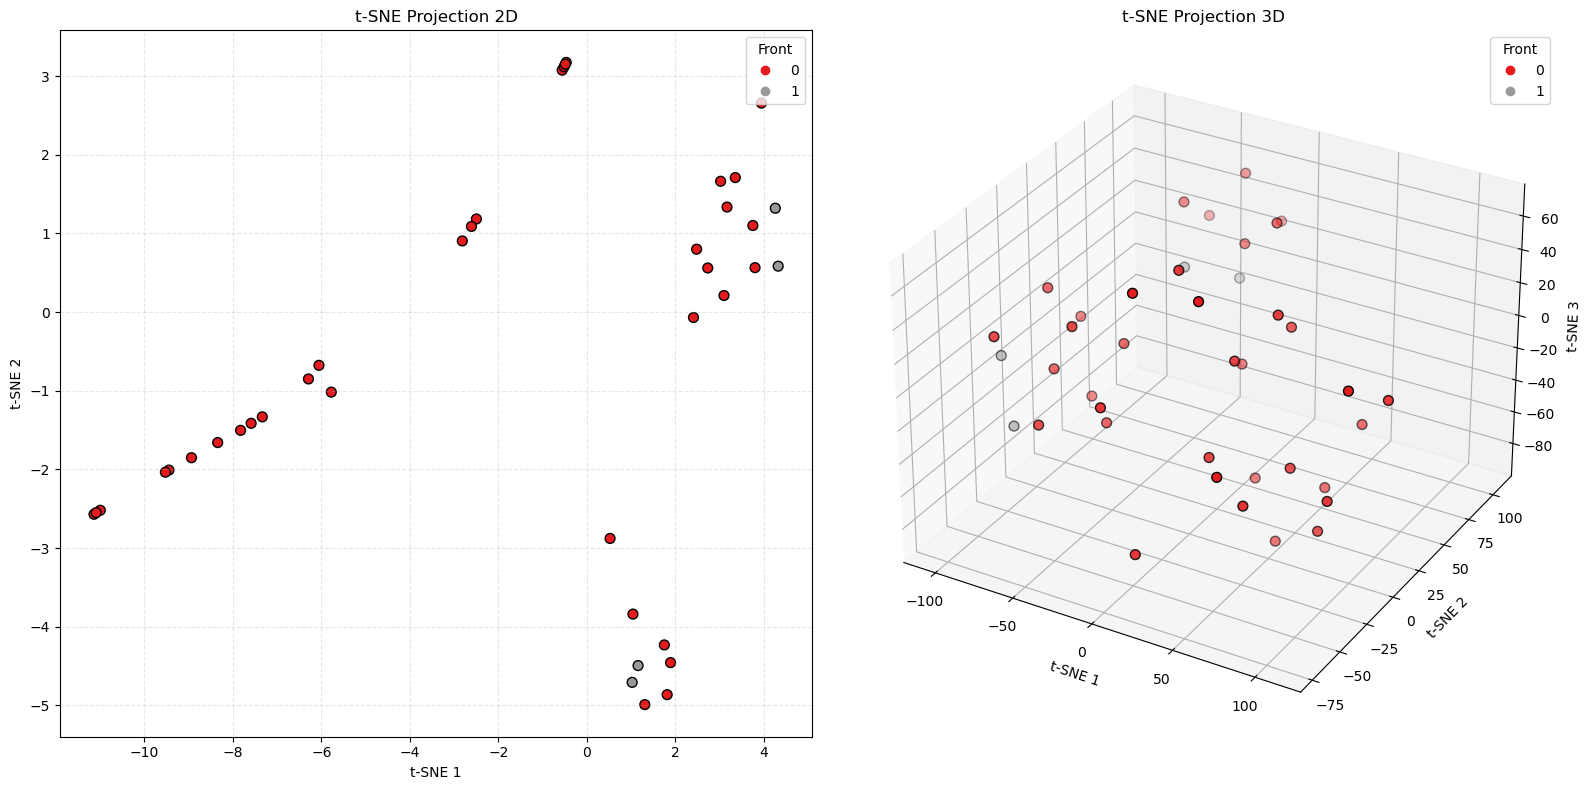

In [129]:
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)  # índice de frente

# Asegurarse de que los datos de entrada son arrays de NumPy
points = np.array(points)
labels = np.array(labels)

# Apply t-SNE
tsne_2d = TSNE(n_components=2, perplexity=10, random_state=42, init='pca', learning_rate='auto')
embedding_2d = tsne_2d.fit_transform(points)

tsne_3d = TSNE(n_components=3, perplexity=10, random_state=42, init='pca', learning_rate='auto')
embedding_3d = tsne_3d.fit_transform(points)

# Create subplots
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1) # 2D subplot

# Plot 2D
scatter_2d = ax1.scatter(embedding_2d[:, 0], embedding_2d[:, 1],
                         c=labels, cmap="Set1", s=50, edgecolors='k')
ax1.set_title("t-SNE Projection 2D")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax1.grid(True, linestyle="--", alpha=0.3)
ax1.legend(*scatter_2d.legend_elements(), title="Front", loc="upper right")

# Plot 3D
ax2 = fig.add_subplot(1, 2, 2, projection='3d') # 3D subplot
scatter_3d = ax2.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],
                         c=labels, cmap="Set1", s=50, edgecolors='k')
ax2.set_title("t-SNE Projection 3D")
ax2.set_xlabel("t-SNE 1")
ax2.set_ylabel("t-SNE 2")
ax2.set_zlabel("t-SNE 3")

# Ajustar diseño y guardar la figura
plt.tight_layout()
plt.savefig(DATASET+"-Type"+str(NODETYPE)+"-tsne.png")

ax2.legend(*scatter_3d.legend_elements(), title="Front", loc="upper right")


## Optimization type BOT

In [130]:
NODETYPE = 1    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics

/home/daniel/miniconda3/envs/tesis/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


{'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 1,
 'x9': 5.722491172010199,
 'x11': 2.154744528081951}

In [131]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")
proj_files = [f for f in os.listdir(proj_dir) if f.endswith(".graphml")]

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

solutions = []
to_df = []
names_df = []
k = 100  # For approximation

for fname in proj_files:
    graph_path = os.path.join(proj_dir, fname)
    gu = ig.Graph.Read_GraphML(graph_path)
    gu = remove_isolated_nodes(gu, k=5)

    # Nombre base del archivo (sin extensión)
    base_name = fname[:-8]
    cache_path = os.path.join(metrics_cache_dir, f"{base_name}_metrics.pkl")

    # Verificar si ya existe un archivo de métricas cacheado
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            proj_metrics = pickle.load(f)
    else:
        k_approx = min(k, gu.vcount())
        proj_metrics = compute_proj_metrics(gu, k_approx)
        with open(cache_path, 'wb') as f:
            pickle.dump(proj_metrics, f)

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(proj_files))
print("Feasible solutions:", len(solutions))


All solutions: 48
Feasible solutions: 32



Frente 1 (18 soluciones):
jaccard_NC_a2
neighs_NC_a2
neighs_NC_a15
jaccard_NC_a15
neighs_DF_a2
vector_DF_a2
jaccard_NC_a05
jaccard_DF_a2
simple_NC_a2
jaccard_NC_a1
vector_DF_a15
simple_NC_a05
vector_DF_a1
neighs_DF_a15
jaccard_DF_a15
resall_NC_a05
neighs_NC_a05
neighs_DF_a1

Frente 2 (9 soluciones):
vector_NC_a05
hyper_NC_a05
simple_NC_a1
vector_NC_a2
hyper_NC_a1
resall_NC_a1
neighs_NC_a1
vector_NC_a15
vector_NC_a1

Frente 3 (5 soluciones):
resall_NC_a15
resall_NC_a2
hyper_NC_a2
simple_NC_a15
hyper_NC_a15

Resumen para AMZ Bot
Proyecciones: {'Jaccard': 6, 'Neighborhood': 7, 'Vectorized': 7, 'Weighted': 4, 'Resource\nAllocation': 4, 'Hyperbolic': 4}
Backbonings: {'Noise Corrected': 24, 'Disparity Filter': 8}
Significancias: {'0.20': 9, '0.15': 9, '0.05': 6, '0.10': 8}


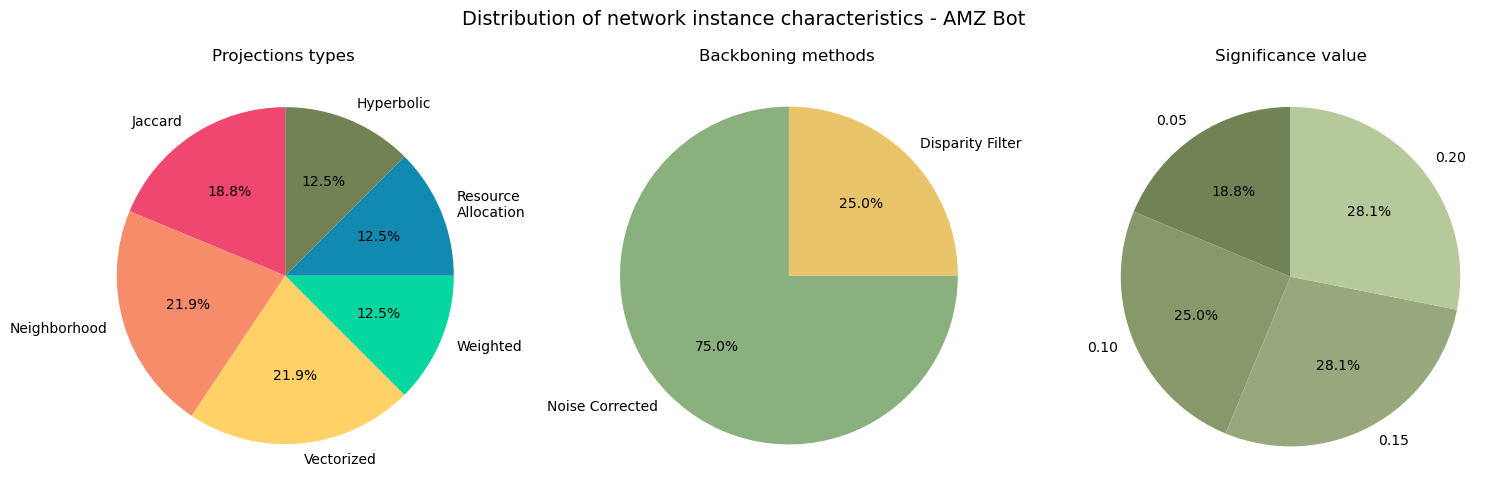

In [132]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][8:]
        print(clean_name)
        counter_sols.append(clean_name)

analizar_frente(counter_sols, DATASET.upper()+" Bot")

In [100]:
cd = crowding_distance(all_fronts[0])
pareto_sorted = [s for _, s in sorted(zip(-cd, all_fronts[0]), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))

Crowding 18


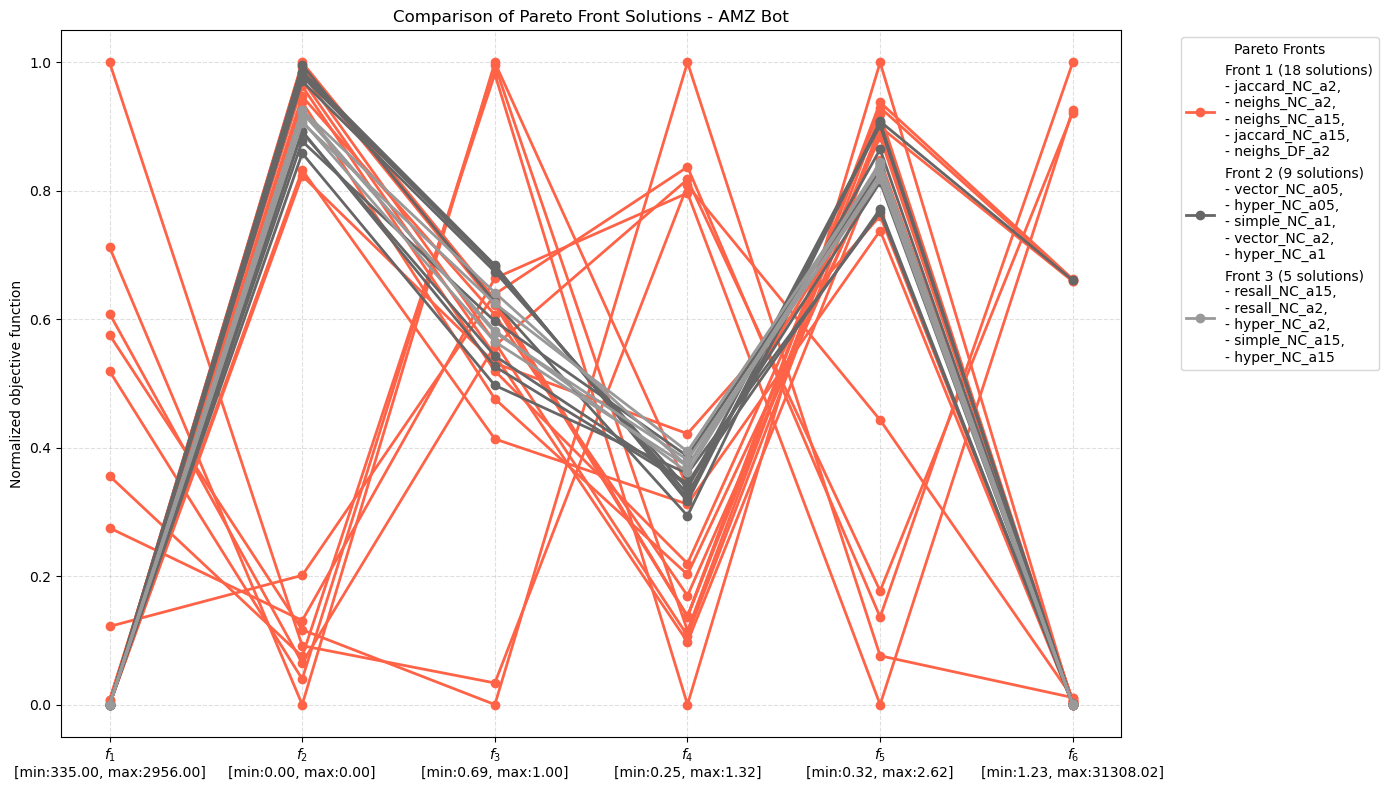

In [118]:
# --- Fin de la simulación de datos ---

labels = ["$f_1$", "$f_2$", "$f_3$", "$f_4$", "$f_5$", "$f_6$"]

# 1. Aplanar la lista de frentes para normalizar todos los datos juntos
todas_las_soluciones = [sol for front in all_fronts for sol in front]
F_all = np.array([sol["f"] for sol in todas_las_soluciones])

# 2. Calcular los valores mínimo y máximo de cada función objetivo
min_vals = F_all.min(axis=0)
max_vals = F_all.max(axis=0)

# 3. Normalizar todos los valores
F_norm_all = (F_all - min_vals) / (max_vals - min_vals + 1e-8)

# 4. Preparar la figura para la gráfica
plt.figure(figsize=(14, 8))

# Generar una escala de grises
num_frentes = len(all_fronts)
# Usar `np.linspace` para generar valores de gris desde un tono oscuro a uno claro.
# Por ejemplo, desde un gris 0.2 (oscuro) hasta 0.8 (claro).
gray_scale = np.linspace(0.2, 0.8, num_frentes+1)

# 5. Recorrer los frentes y las soluciones para graficar
idx_solucion = 0
for i, front in enumerate(all_fronts):
    rank = i + 1
    num_sols = len(front)

    # Asignar el color del frente
    if i == 0:
        color = "tomato"
    else:
        color = str(gray_scale[i])

    # Generar nombres de soluciones (puedes ajustar esto si tus soluciones tienen un identificador propio)
    nombres_soluciones = [sol.get("filename", f"sol_{idx_solucion + j}") for j, sol in enumerate(front)]
    nombres_soluciones = [i[8:] for i in nombres_soluciones]
    nombres_mostrados = ",\n- ".join(nombres_soluciones[:5])
    
    # Etiqueta extendida para la leyenda
    label_front = f"Front {rank} ({num_sols} solutions)"
    if num_sols > 0:
        label_front += f"\n- {nombres_mostrados}"

    for j, sol in enumerate(front):
        F_norm_solucion = F_norm_all[idx_solucion]

        # Solo la primera solución del frente tiene leyenda
        if j == 0:
            label = label_front
        else:
            label = None

        plt.plot(
            labels,
            F_norm_solucion,
            color=color,
            linestyle='-',
            linewidth=2,
            marker='o',
            label=label
        )
        
        idx_solucion += 1


# 6. Actualizar las etiquetas del eje X con los rangos de valores reales
new_labels = [f"{lbl}\n[min:{min_v:.2f}, max:{max_v:.2f}]" for lbl, min_v, max_v in zip(labels, min_vals, max_vals)]
plt.xticks(range(len(new_labels)), new_labels, rotation=0)

# 7. Configurar y guardar la gráfica
plt.ylabel("Normalized objective function")
plt.title("Comparison of Pareto Front Solutions - " + DATASET.upper() + " Bot")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Pareto Fronts", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(DATASET+"-Type"+str(NODETYPE)+"-pf.png")
plt.show()


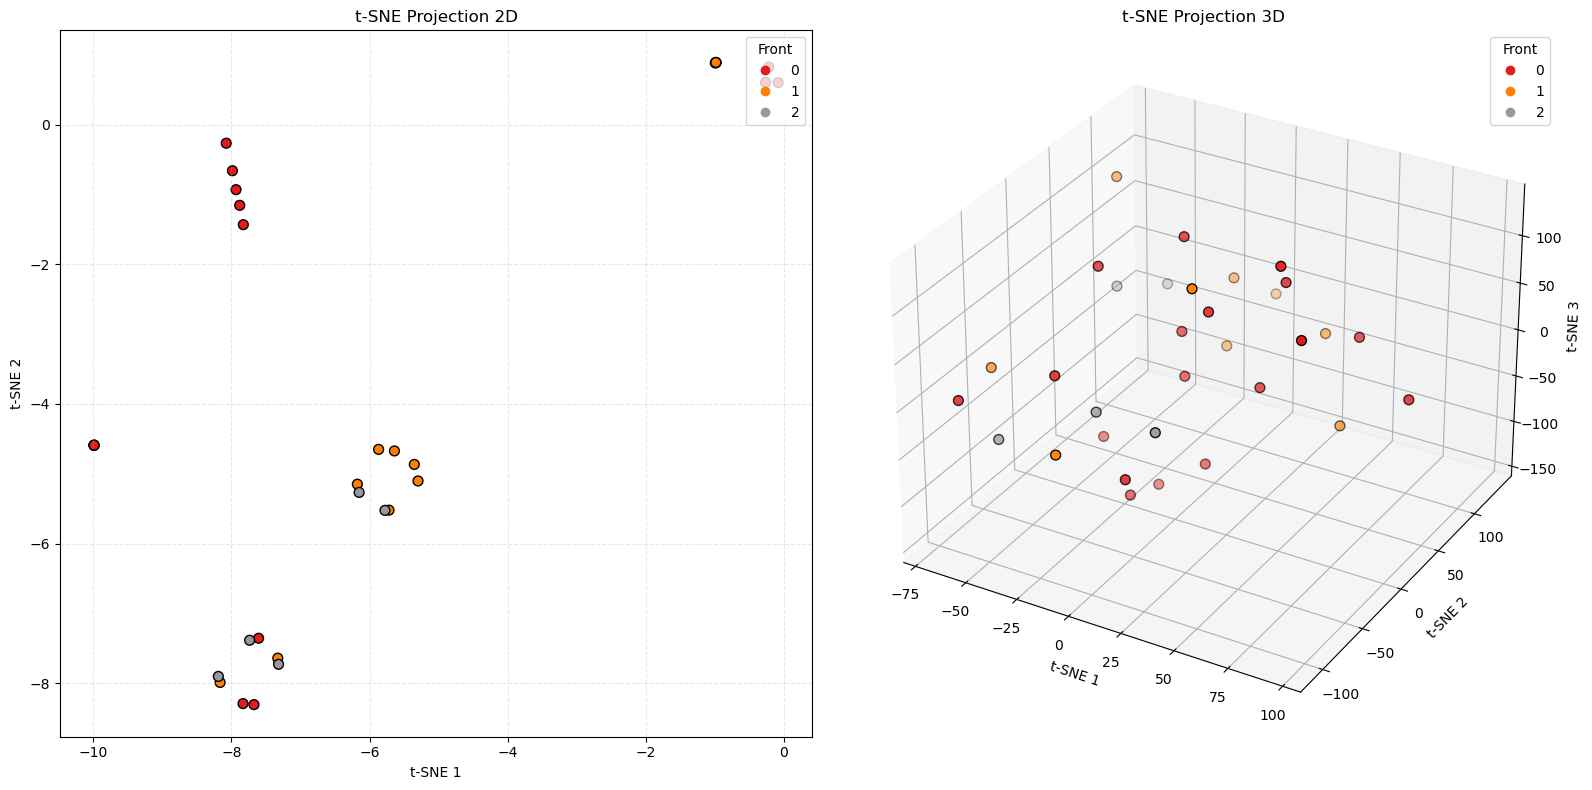

In [89]:
points = []
labels = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)  # índice de frente

# Asegurarse de que los datos de entrada son arrays de NumPy
points = np.array(points)
labels = np.array(labels)

# Apply t-SNE
tsne_2d = TSNE(n_components=2, perplexity=10, random_state=42, init='pca', learning_rate='auto')
embedding_2d = tsne_2d.fit_transform(points)

tsne_3d = TSNE(n_components=3, perplexity=10, random_state=42, init='pca', learning_rate='auto')
embedding_3d = tsne_3d.fit_transform(points)

# Create subplots
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1) # 2D subplot

# Plot 2D
scatter_2d = ax1.scatter(embedding_2d[:, 0], embedding_2d[:, 1],
                         c=labels, cmap="Set1", s=50, edgecolors='k')
ax1.set_title("t-SNE Projection 2D")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax1.grid(True, linestyle="--", alpha=0.3)
ax1.legend(*scatter_2d.legend_elements(), title="Front", loc="upper right")

# Plot 3D
ax2 = fig.add_subplot(1, 2, 2, projection='3d') # 3D subplot
scatter_3d = ax2.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],
                         c=labels, cmap="Set1", s=50, edgecolors='k')
ax2.set_title("t-SNE Projection 3D")
ax2.set_xlabel("t-SNE 1")
ax2.set_ylabel("t-SNE 2")
ax2.set_zlabel("t-SNE 3")
ax2.legend(*scatter_3d.legend_elements(), title="Front", loc="upper right")

# Ajustar diseño y guardar la figura
plt.tight_layout()
plt.savefig(DATASET+"-Type"+str(NODETYPE)+"-tsne.png")

FIN